# Pneumonia Detection from Chest X-ray through Deep Learning

## I. Overview

## II. Business Problem

## III. Data Understanding and Preparation
- The datasets acquired from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) were downloaded in a "chest_xray" folder. This folder has 3 sub-folders inside which are "train", "test", and "val". Each sub-folder contains 2 sub-folders: "NORMAL" and "PNEUMONIA"

In [19]:
import os

import pandas as pd
import numpy as np
np.random.seed(24)
# Set for displaying prediction probability for later
np.set_printoptions(precision=6, suppress=True)  # if absolute value < 1e-4, set equal to 0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [20]:
from google.colab import drive

In [21]:
from tensorflow import random
random.set_seed(24)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_reportreport

# Implementation of the scikit-learn classifier API for Keras
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get the current working directory
print(os.getcwd())

In [20]:
# Drive path is the path where I upload the zip file
drive_path = '/gdrive/MyDrive/chest_xray.zip'

# Expect to move the zip file into the local path
local_path = '/content'

In [25]:
# Copy the file in drive path
!cp '{drive_path}' .

# Change the file from drive path to the local path
os.chdir(local_path)

# Unzip the file
!unzip -q 'chest_xray.zip'

In [28]:
# Check the number of images in each sub-folders

# Train
train_normal = '/content/chest_xray/train/NORMAL'
train_pneumonia = '/content/chest_xray/train/PNEUMONIA'

print("Train Normal:", len(os.listdir(train_normal)))
print("Train Pneumonia:", len(os.listdir(train_pneumonia)))
print("Train Total:", len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia)))

# Test
test_normal = '/content/chest_xray/test/NORMAL'
test_pneumonia = '/content/chest_xray/test/PNEUMONIA'

print("\nTest Normal:", len(os.listdir(test_normal)))
print("Test Pneumonia:", len(os.listdir(test_pneumonia)))
print("Test Total:", len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia)))

# Validation
val_normal = '/content/chest_xray/val/NORMAL'
val_pneumonia = '/content/chest_xray/val/PNEUMONIA'

print("\nVal Normal:", len(os.listdir(val_normal)))
print("Val Pneumonia:", len(os.listdir(val_pneumonia)))
print("Val Total:", len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia)))

Train Normal: 1341
Train Pneumonia: 3875
Train Total: 5216

Test Normal: 234
Test Pneumonia: 390
Test Total: 624

Val Normal: 8
Val Pneumonia: 8
Val Total: 16


In [29]:
# Create file directory
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [30]:
# Create data generator
# Get all the train data (5216), test data (624), validation data (16) in the corresponding directory
# Scale data
# Set each image to 128×128 px
# Set binary class mode

train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216, class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624, class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16, class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [31]:
# Create the data sets
# next - retrieve the next item from iterator
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [32]:
# Check the shape
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))

print ("\nX_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

print ("\nX_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

X_train shape: (5216, 128, 128, 3)
y_train shape: (5216,)

X_test shape: (624, 128, 128, 3)
y_test shape: (624,)

X_val shape: (16, 128, 128, 3)
y_val shape: (16,)


In [33]:
# Check if the binary indicator was correctly labeled
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [34]:
# Create two lists for storing the image number from validation set
normal_img_num = []
pneumonia_img_num = []

# Validation set only contains 16 images
# target label = 0 means normal
# target label = 1 means pneumonis

numbers = list(range(0,16))
for num in numbers:
    
    if y_val[num] == 0:
        normal_img_num.append(num)
    
    else:
        pneumonia_img_num.append(num)

print(normal_img_num)
print(pneumonia_img_num)

[1, 3, 5, 6, 8, 9, 12, 14]
[0, 2, 4, 7, 10, 11, 13, 15]


0.0
1.0


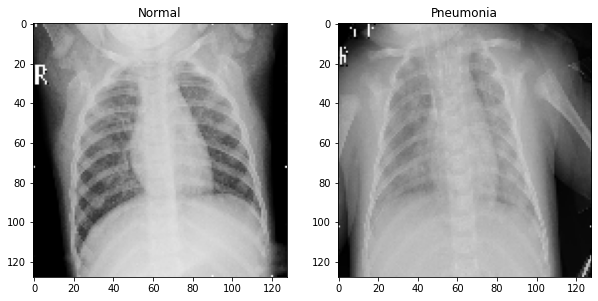

In [35]:
# Plot one image from each list 
# Choose the 1st image from each list
fig = plt.figure(figsize=(10,10))
n = 0

# Normal
ax1 = fig.add_subplot(121)
plt.imshow(X_val[normal_img_num[n]])
print(y_val[normal_img_num[n]])
plt.title("Normal");

# Pneumonia
ax2 = fig.add_subplot(122)
plt.imshow(X_val[pneumonia_img_num[n]])
print(y_val[pneumonia_img_num[n]])
plt.title("Pneumonia");

In [36]:
def visualize_training_results(history):
    '''
    Input: keras history object 
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [37]:
def model_evaluation(model):
    '''
    Input: keras model
    
    Append accuracy results
    
    Plot confusion matrix
    '''
    
    train_acc = []
    test_acc = []
    
    # Train loss and accuracy
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    train_acc.append(round(result_train[1], 4))
    
    # Test loss and accuracy
    result_test = model.evaluate(X_test, y_test)
    print(f'Test Loss:{result_test[0]:.4}')
    print(f'Test Accuracy:{result_test[1]:.4}')
    test_acc.append(round(result_test[1], 4))
    
    # Prediction
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    ax.set_ylim(2,0)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    
    # Classification Report
    print(classification_report(y_test, y_test_pred))
    
    return train_acc, test_acc

### Note:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step
- <u>*validation set*</u> will be used as true holdout which only use at the end 

### Problem of small validation set
- If the validation set contains much less data than training set, the validation curves (accuracy and loss) will be spiky before convergence. In other words, more epochs and longer training time will be required

## IV. Modeling

### CNN Baseline Model

In [65]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [66]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 21ms/step - loss: 0.4303 - accuracy: 0.8152 - val_loss: 1.1098 - val_accuracy: 0.7212
Epoch 2/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1145 - accuracy: 0.9550 - val_loss: 0.5855 - val_accuracy: 0.8109
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.0777 - accuracy: 0.9707 - val_loss: 0.9440 - val_accuracy: 0.7484
Epoch 4/50
163/163 [==============================] - 3s 20ms/step - loss: 0.0714 - accuracy: 0.9715 - val_loss: 0.6994 - val_accuracy: 0.8013
Epoch 5/50
163/163 [==============================] - 3s 20ms/step - loss: 0.0548 - accuracy: 0.9795 - val_loss: 1.0496 - val_accuracy: 0.7821
Epoch 6/50
163/163 [==============================] - 3s 20ms/step - loss: 0.0437 - accuracy: 0.9839 - val_loss: 1.5179 - val_accuracy: 0.7516
Epoch 7/50
163/163 [==============================] - 3s 20ms/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 1.3001 - val_accuracy: 0.7660

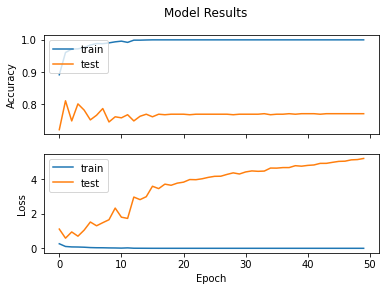

In [67]:
visualize_training_results(base_history)

In [68]:
base_model.save('/content/saved_models/base_model.h5')

163/163 [==============================] - 1s 7ms/step - loss: 1.2693e-06 - accuracy: 1.0000
Training Loss:1.269e-06
Training Accuracy:1.0
20/20 [==============================] - 0s 7ms/step - loss: 5.1855 - accuracy: 0.7708
Test Loss:5.185
Test Accuracy:0.7708


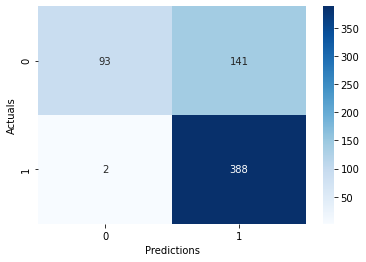

([1.0], [0.7708])

In [69]:
base = load_model('/content/saved_models/base_model.h5')
bm = model_evaluation(base)
bm

>**Comment:** *Baseline Model*
- The CNN baseline model took more than 40 minutes to run
- The train accuracy (100%) is higher than val accuracy (0.753) which indicates that the baseline model is overfit
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
- Early stopping can be used for iteration model tunning to prevent overfit and saving time
- There are more false positive than false negative

### Early Stopping

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6)

### Solve Overfitting Technique
1. Dropout
2. Regularization, L1, L2, L1+L2

### 1) Dropout 20
- Add (20%) dropout layers and earlystopping 

In [70]:
dropout_20 = models.Sequential()
dropout_20.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Flatten())
dropout_20.add(layers.Dense(128, activation='relu'))
dropout_20.add(layers.Dense(1, activation='sigmoid'))

dropout_20.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [71]:
mc_dp_20 = ModelCheckpoint(filepath='/content/saved_models/dropout_20.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [72]:
dropout_20_history = dropout_20.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=[es, mc_dp_20],
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 22ms/step - loss: 0.5606 - accuracy: 0.7662 - val_loss: 0.9235 - val_accuracy: 0.7260

Epoch 00001: val_accuracy improved from -inf to 0.72596, saving model to /content/saved_models/best_dropout_20.h5
Epoch 2/50
163/163 [==============================] - 4s 21ms/step - loss: 0.1552 - accuracy: 0.9388 - val_loss: 0.6252 - val_accuracy: 0.8029

Epoch 00002: val_accuracy improved from 0.72596 to 0.80288, saving model to /content/saved_models/best_dropout_20.h5
Epoch 3/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1018 - accuracy: 0.9622 - val_loss: 0.9918 - val_accuracy: 0.7404

Epoch 00003: val_accuracy did not improve from 0.80288
Epoch 4/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0996 - accuracy: 0.9673 - val_loss: 0.7593 - val_accuracy: 0.7981

Epoch 00004: val_accuracy did not improve from 0.80288
Epoch 5/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0667 -

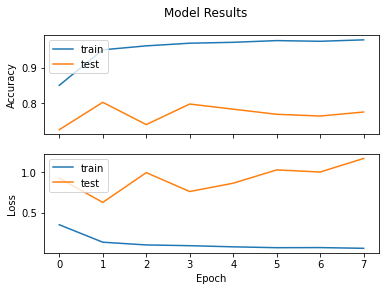

In [73]:
visualize_training_results(dropout_20_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1052 - accuracy: 0.9632
Training Loss:0.1052
Training Accuracy:0.9632
20/20 [==============================] - 0s 8ms/step - loss: 0.6252 - accuracy: 0.8029
Test Loss:0.6252
Test Accuracy:0.8029


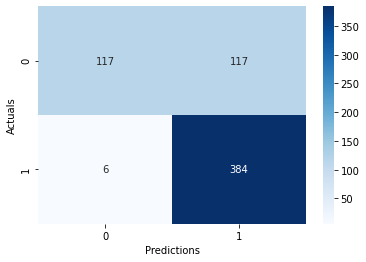

([0.9632], [0.8029])

In [74]:
dp20 = load_model('/content/saved_models/dropout_20.h5')
dp20m = model_evaluation(dp20)
dp20m

>**Comment:** Dropout 20%
- The dropout_20 model took less time to run compare with the baseline model
- The train accuracy (0.9659) is higher than test accuracy (0.7997) which indicates the model is overfit 
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative
- dp20 has more FN than base

#### Grid Search for dropout %

In [ ]:
def dropout_model(percent):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

https://faroit.com/keras-docs/1.0.6/scikit-learn-api/

In [ ]:
# Wrapper
DP_model = KerasClassifier(build_fn=dropout_model)

In [ ]:
# parameter grid
dp_param_grid = {'percent': [0.2, 0.3, 0.4, 0.5]}

DP_grid = GridSearchCV(DP_model, param_grid=dp_param_grid, cv=3)

In [ ]:
DP_grid_history = DP_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

In [ ]:
# Find the best weight_decay value
DP_grid_history.best_params_

In [ ]:
# DP_grid_history.best_score_

In [ ]:
# DP_grid_history.cv_results_

In [ ]:
# DP_grid_history.score(X_test, y_test)

### Best Dropout
- Add (50%) dropout layer and earlystopping

In [75]:
dropout_50 = models.Sequential()
dropout_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Flatten())
dropout_50.add(layers.Dense(128, activation='relu'))
dropout_50.add(layers.Dense(1, activation='sigmoid'))

dropout_50.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [76]:
mc_dp_50 = ModelCheckpoint(filepath='/content/saved_models/best_dropout_50.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [77]:
dropout_50_history = dropout_50.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=[es, mc_dp_50],
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 23ms/step - loss: 0.8368 - accuracy: 0.6998 - val_loss: 0.3846 - val_accuracy: 0.8349

Epoch 00001: val_accuracy improved from -inf to 0.83494, saving model to /content/saved_models/best_dropout_50.h5
Epoch 2/50
163/163 [==============================] - 3s 21ms/step - loss: 0.2143 - accuracy: 0.9161 - val_loss: 0.5772 - val_accuracy: 0.7436

Epoch 00002: val_accuracy did not improve from 0.83494
Epoch 3/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1575 - accuracy: 0.9399 - val_loss: 0.4640 - val_accuracy: 0.7821

Epoch 00003: val_accuracy did not improve from 0.83494
Epoch 4/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1380 - accuracy: 0.9495 - val_loss: 0.5296 - val_accuracy: 0.7692

Epoch 00004: val_accuracy did not improve from 0.83494
Epoch 5/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1182 - accuracy: 0.9540 - val_loss: 0.5277 - val_accuracy: 0.7756

E

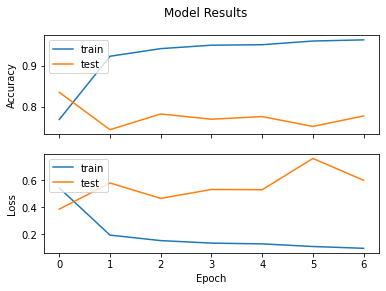

In [78]:
visualize_training_results(dropout_50_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.2802 - accuracy: 0.9114
Training Loss:0.2802
Training Accuracy:0.9114
20/20 [==============================] - 0s 8ms/step - loss: 0.3846 - accuracy: 0.8349
Test Loss:0.3846
Test Accuracy:0.8349


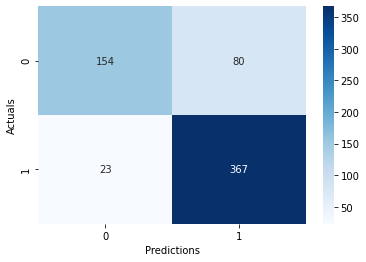

([0.9114], [0.8349])

In [79]:
dp50 = load_model('/content/saved_models/best_dropout_50.h5')
dp50m = model_evaluation(dp50)
dp50m

>**Comment:**
- The dropout_50 model took less time to run compare with the baseline model
- The train accuracy (0.9709) is higher than test accuracy (0.7869) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- Compare with dp20, test accuracy is slightly lower
    Decrease the complexity => lose some useful information?
- There are more false positive than false negative

### 2) L2 Regularizer

https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

L2 hyperparameter choosing https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

In [80]:
L2_reg = models.Sequential()
L2_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), 
                         activation='relu', input_shape=X_train.shape[1:]))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Flatten())
L2_reg.add(layers.Dense(128, activation='relu'))
L2_reg.add(layers.Dense(1, activation='sigmoid'))

L2_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [81]:
mc_L2_reg = ModelCheckpoint(filepath='/content/saved_models/L2_reg.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [82]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=[es, mc_L2_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 21ms/step - loss: 0.8313 - accuracy: 0.7861 - val_loss: 1.0609 - val_accuracy: 0.7196

Epoch 00001: val_accuracy improved from -inf to 0.71955, saving model to /content/saved_models/best_L2.h5
Epoch 2/50
163/163 [==============================] - 3s 20ms/step - loss: 0.2493 - accuracy: 0.9551 - val_loss: 0.7727 - val_accuracy: 0.7821

Epoch 00002: val_accuracy improved from 0.71955 to 0.78205, saving model to /content/saved_models/best_L2.h5
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1846 - accuracy: 0.9614 - val_loss: 0.8393 - val_accuracy: 0.7596

Epoch 00003: val_accuracy did not improve from 0.78205
Epoch 4/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1672 - accuracy: 0.9645 - val_loss: 0.8755 - val_accuracy: 0.7596

Epoch 00004: val_accuracy did not improve from 0.78205
Epoch 5/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1309 - accuracy: 0.974

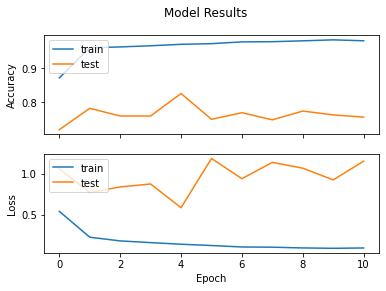

In [83]:
visualize_training_results(L2_reg_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1566 - accuracy: 0.9617
Training Loss:0.1566
Training Accuracy:0.9617
20/20 [==============================] - 0s 8ms/step - loss: 0.5866 - accuracy: 0.8253
Test Loss:0.5866
Test Accuracy:0.8253


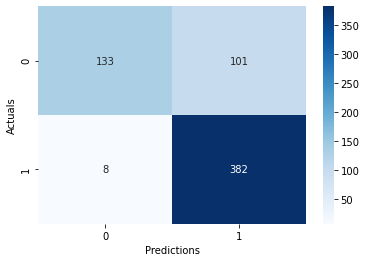

([0.9617], [0.8253])

In [84]:
L2 = load_model('/content/saved_models/L2_reg.h5')
L2m = model_evaluation(L2)
L2m

>**Comment:** 
- The L2 took less time to run compare with the baseline model
- The train accuracy (0.9442) is higher than test accuracy (0.8446) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

#### Grid Search For L2 weight decay

GridSearch https://heartbeat.fritz.ai/introduction-to-deep-learning-with-keras-c7c3d14e1527

In [56]:
def L2_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [58]:
L2_model = KerasClassifier(build_fn=L2_regularizer_model)

In [ ]:
# parameter grid
reg_param_grid = {'weight_decay': [0.5, 0.05, 0.005, 0.0005]}

In [59]:
L2_grid = GridSearchCV(L2_model, param_grid=reg_param_grid, cv=3)

In [60]:
L2_grid_history = L2_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 25ms/step - loss: 28.7311 - accuracy: 0.7446 - val_loss: 0.8945 - val_accuracy: 0.7228
Epoch 2/50
109/109 [==============================] - 2s 21ms/step - loss: 0.4407 - accuracy: 0.9126 - val_loss: 0.7479 - val_accuracy: 0.7372
Epoch 3/50
109/109 [==============================] - 2s 21ms/step - loss: 0.2830 - accuracy: 0.9234 - val_loss: 0.5918 - val_accuracy: 0.7869
Epoch 4/50
109/109 [==============================] - 2s 21ms/step - loss: 0.2855 - accuracy: 0.9263 - val_loss: 0.6774 - val_accuracy: 0.7580
Epoch 5/50
109/109 [==============================] - 2s 21ms/step - loss: 0.2508 - accuracy: 0.9338 - val_loss: 0.5414 - val_accuracy: 0.7933
Epoch 6/50
109/109 [==============================] - 2s 21ms/step - loss: 0.2498 - accuracy: 0.9335 - val_loss: 1.0724 - val_accuracy: 0.6715
Epoch 7/50
109/109 [==============================] - 2s 21ms/step - loss: 0.2653 - accuracy: 0.9240 - val_loss: 0.7180 - val_accuracy: 0.762

In [61]:
# Find the best weight_decay value
L2_grid_history.best_params_

{'weight_decay': 0.005}

In [62]:
# grid_history.best_score_

0.9710492094357809

In [63]:
# grid_history.cv_results_

{'mean_fit_time': array([21.286398, 19.7284  , 28.567023, 25.789003]),
 'mean_score_time': array([0.629992, 0.590011, 0.601974, 0.598321]),
 'mean_test_score': array([0.934243, 0.962998, 0.971049, 0.971049]),
 'param_weight_decay': masked_array(data=[0.5, 0.05, 0.005, 0.0005],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'weight_decay': 0.5},
  {'weight_decay': 0.05},
  {'weight_decay': 0.005},
  {'weight_decay': 0.0005}],
 'rank_test_score': array([4, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.923519, 0.966072, 0.974123, 0.976998]),
 'split1_test_score': array([0.93387 , 0.959747, 0.975273, 0.973548]),
 'split2_test_score': array([0.945339, 0.963176, 0.963751, 0.962601]),
 'std_fit_time': array([3.924649, 1.970564, 7.150637, 8.920431]),
 'std_score_time': array([0.04408 , 0.00707 , 0.007733, 0.012888]),
 'std_test_score': array([0.008912, 0.002585, 0.005182, 0.006138])}

In [64]:
# grid_history.score(X_test, y_test)

20/20 [==============================] - 0s 9ms/step - loss: 1.1628 - accuracy: 0.7580


0.7580128312110901

https://datascience.stackexchange.com/questions/77881/whats-the-difference-between-gridsearchcrossvalidation-score-and-score-on-tests#:~:text=Grid%20search%20trains%20different%20models,score%20of%20the%20best%20estimator.&text=It%20means%20that%20the%20model,not%20on%20the%20unseen%20data.

### Best L2 (weight decay)

In [ ]:
L2_wd = models.Sequential()
L2_wd.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), 
                         activation='relu', input_shape=X_train.shape[1:]))
L2_wd.add(layers.MaxPooling2D((2, 2)))

L2_wd.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_wd.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Flatten())
L2_reg.add(layers.Dense(128, activation='relu'))
L2_reg.add(layers.Dense(1, activation='sigmoid'))

L2_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
mc_L2_reg = ModelCheckpoint(filepath='/content/saved_models/L2_reg.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

### 3) L1 Regularizer

In [ ]:
L1_reg = models.Sequential()
L1_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(0.005), 
                         activation='relu', input_shape=X_train.shape[1:]))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Flatten())
L1_reg.add(layers.Dense(128, activation='relu'))
L1_reg.add(layers.Dense(1, activation='sigmoid'))

L1_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
mc_L1_reg = ModelCheckpoint(filepath='/content/saved_models/L1_reg.h5', monitor='val_accuracy', 
                            mode='max', verbose=1, save_best_only=True)

In [ ]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=[es, mc_L1_reg],
                            validation_data=(X_test, y_test))

In [ ]:
visualize_training_results(L1_reg_history)

In [ ]:
L1 = load_model('/content/saved_models/L1_reg.h5')
L1m = model_evaluation(L1)
L1m

#### Grid Search For L1 weight decay

In [ ]:
def L1_regularizer_model(weight_decay):
    
    # Build the model with L2 regularizer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(weight_decay), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
L1_model = KerasClassifier(build_fn=L1_regularizer_model)

In [ ]:
L1_grid = GridSearchCV(L1_model, param_grid=reg_param_grid, cv=3)

In [ ]:
L1_grid_history = L1_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es,
                              validation_data=(X_test, y_test))

In [ ]:
# Find the best weight_decay value
L1_grid_history.best_params_

### Best Model (L2 0.0005)

In [ ]:
L2_best = models.Sequential()
L2_best.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.0005), 
                                      activation='relu', input_shape=X_train.shape[1:]))
L2_best.add(layers.MaxPooling2D((2, 2)))

L2_best.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
L2_best.add(layers.MaxPooling2D((2, 2)))

L2_best.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
L2_best.add(layers.MaxPooling2D((2, 2)))

L2_best.add(layers.Flatten())
L2_best.add(layers.Dense(128, activation='relu'))
L2_best.add(layers.Dense(1, activation='sigmoid'))

L2_best.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
es_L2_best = [EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6),
              ModelCheckpoint(filepath='saved_models/L2_best.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [ ]:
L2_best_history = L2_best.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es_L2_best,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 42s 253ms/step - loss: 0.5629 - accuracy: 0.7813 - val_loss: 1.0858 - val_accuracy: 0.6843

Epoch 00001: val_accuracy improved from -inf to 0.68429, saving model to saved_models/L2_best.h5
Epoch 2/50
163/163 [==============================] - 42s 256ms/step - loss: 0.1465 - accuracy: 0.9577 - val_loss: 0.7735 - val_accuracy: 0.7837

Epoch 00002: val_accuracy improved from 0.68429 to 0.78365, saving model to saved_models/L2_best.h5
Epoch 3/50
163/163 [==============================] - 41s 253ms/step - loss: 0.1315 - accuracy: 0.9668 - val_loss: 0.5174 - val_accuracy: 0.8269

Epoch 00003: val_accuracy improved from 0.78365 to 0.82692, saving model to saved_models/L2_best.h5
Epoch 4/50
163/163 [==============================] - 41s 249ms/step - loss: 0.1226 - accuracy: 0.9652 - val_loss: 1.0259 - val_accuracy: 0.7676

Epoch 00004: val_accuracy did not improve from 0.82692
Epoch 5/50
163/163 [==============================] - 41s 249ms/

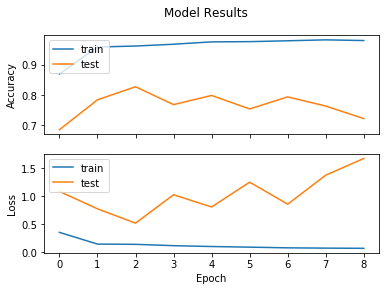

In [ ]:
visualize_training_results(L2_best_history)

163/163 [==============================] - 10s 61ms/step - loss: 0.1378 - accuracy: 0.9592
Training Loss:0.1378
Training Accuracy:0.9592
20/20 [==============================] - 1s 61ms/step - loss: 0.5174 - accuracy: 0.8269
Test Loss:0.5174
Test Accuracy:0.8269


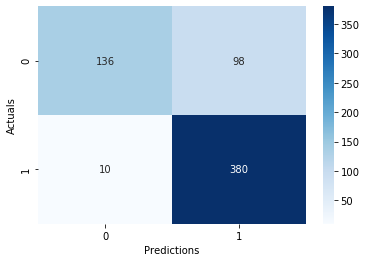

([0.9592], [0.8269])

In [ ]:
L2best = load_model('saved_models/L2_best.h5')
model_evaluation(L2best)

### 4) L1 + L2

In [ ]:
def L1_L2_regularizer_model(wd_1, wd_2):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu', input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
L_model = KerasClassifier(build_fn=L1_L2_regularizer_model)

In [ ]:
# parameter grid
l1l2_param_grid = {'wd_1': [0.5, 0.05, 0.005, 0.0005],
                   'wd_2': [0.5, 0.05, 0.005, 0.0005]}

L_grid = GridSearchCV(L_model, param_grid=l1l2_param_grid, cv=3)

In [ ]:
L_grid_history = L_grid.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es,
                            validation_data=(X_test, y_test))

In [ ]:
# Find the best weight_decay value
L_grid_history.best_params_

### 5) Padding

https://deepai.org/machine-learning-glossary-and-terms/padding#:~:text=In%20order%20to%20assist%20the,more%20accurate%20analysis%20of%20images.

In [ ]:
padding = models.Sequential()
padding.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Flatten())
padding.add(layers.Dense(128, activation='relu'))
padding.add(layers.Dense(1, activation='sigmoid'))

padding.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
mc_padding = ModelCheckpoint(filepath='/content/saved_models/padding.h5', 
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [ ]:
padding_history = padding.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=[es, mc_padding],
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 50s 302ms/step - loss: 0.5563 - accuracy: 0.7632 - val_loss: 0.9447 - val_accuracy: 0.7244

Epoch 00001: val_accuracy improved from -inf to 0.72436, saving model to saved_models/best_padding.h5
Epoch 2/50
163/163 [==============================] - 47s 287ms/step - loss: 0.1118 - accuracy: 0.9594 - val_loss: 0.8752 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.72436 to 0.75641, saving model to saved_models/best_padding.h5
Epoch 3/50
163/163 [==============================] - 47s 289ms/step - loss: 0.0956 - accuracy: 0.9680 - val_loss: 0.7980 - val_accuracy: 0.7804

Epoch 00003: val_accuracy improved from 0.75641 to 0.78045, saving model to saved_models/best_padding.h5
Epoch 4/50
163/163 [==============================] - 47s 288ms/step - loss: 0.0781 - accuracy: 0.9728 - val_loss: 1.6736 - val_accuracy: 0.6971

Epoch 00004: val_accuracy did not improve from 0.78045
Epoch 5/50
163/163 [=============================

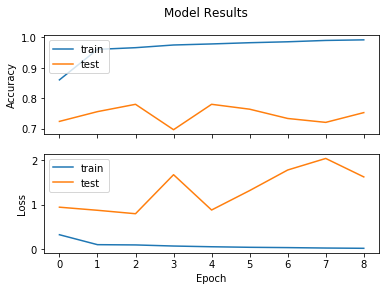

In [ ]:
visualize_training_results(padding_history)

163/163 [==============================] - 12s 74ms/step - loss: 0.0582 - accuracy: 0.9785
Training Loss:0.05816
Training Accuracy:0.9785
20/20 [==============================] - 2s 74ms/step - loss: 0.7980 - accuracy: 0.7804
Test Loss:0.798
Test Accuracy:0.7804


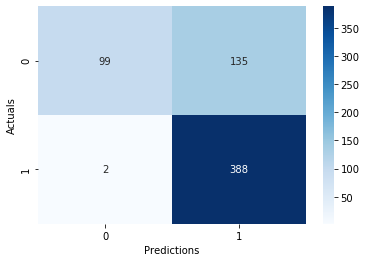

([0.9785], [0.7804])

In [ ]:
pad = load_model('/content/saved_models/padding.h5')
padd = model_evaluation(pad)
padd

>**Comment:** 
- The Padding took less time to run compare with the baseline model
- The train accuracy (0.9785) is higher than test accuracy (0.7804) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

#### Padding + L1 L2

In [ ]:
L_padding = models.Sequential()
L_padding.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005),
                          padding='same', activation='relu', input_shape=X_train.shape[1:]))
L_padding.add(layers.MaxPooling2D((2, 2)))

L_padding.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005),
                          padding='same', activation='relu'))
L_padding.add(layers.MaxPooling2D((2, 2)))

L_padding.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005),
                          padding='same', activation='relu'))
L_padding.add(layers.MaxPooling2D((2, 2)))

L_padding.add(layers.Flatten())
L_padding.add(layers.Dense(128, activation='relu'))
L_padding.add(layers.Dense(1, activation='sigmoid'))

L_padding.compile(optimizer='adam',
                  loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
mc_L_padding = ModelCheckpoint(filepath='/content/saved_models/L_padding.h5', 
                               monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
L_padding_history = L_padding.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  callbacks=[es, mc_L_padding],
                                  validation_data=(X_test, y_test))

In [ ]:
visualize_training_results(L_padding_history)

In [ ]:
Lpad = load_model('/content/saved_models/L_padding.h5')
LP = model_evaluation(Lpad)
LP

### 6) Pretrained VGG19

In [38]:
from keras.applications import VGG19

In [39]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=X_train.shape[1:])

80142336/80134624 [==============================] - 1s 0us/step


In [40]:
pre = models.Sequential()
pre.add(pretrained)
pre.add(layers.Flatten())
pre.add(layers.Dense(128, activation='relu'))
pre.add(layers.Dense(1, activation='sigmoid'))

# Freeze pretained layer
pretrained.trainable = False

In [41]:
pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
# Verify "frozen"
for layer in pre.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten True
dense True
dense_1 True


In [43]:
pre.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [44]:
mc_pre = ModelCheckpoint(filepath='/content/saved_models/pre.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [85]:
pre_history = pre.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      callbacks=[es, mc_pre],
                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 9s 56ms/step - loss: 0.0206 - accuracy: 0.9921 - val_loss: 1.4883 - val_accuracy: 0.7420

Epoch 00001: val_accuracy did not improve from 0.82692
Epoch 2/50
163/163 [==============================] - 9s 56ms/step - loss: 0.0159 - accuracy: 0.9944 - val_loss: 1.3385 - val_accuracy: 0.7612

Epoch 00002: val_accuracy did not improve from 0.82692
Epoch 3/50
163/163 [==============================] - 9s 57ms/step - loss: 0.0160 - accuracy: 0.9941 - val_loss: 1.0398 - val_accuracy: 0.8125

Epoch 00003: val_accuracy did not improve from 0.82692
Epoch 4/50
163/163 [==============================] - 9s 57ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.7635 - val_accuracy: 0.8413

Epoch 00004: val_accuracy improved from 0.82692 to 0.84135, saving model to /content/saved_models/best_pre.h5
Epoch 5/50
163/163 [==============================] - 9s 58ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.8857 - val_accuracy: 0.8397

Epoch

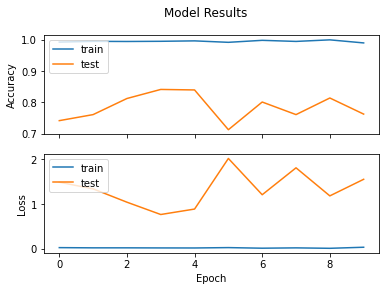

In [86]:
visualize_training_results(pre_history)

163/163 [==============================] - 8s 49ms/step - loss: 0.0455 - accuracy: 0.9804
Training Loss:0.04553
Training Accuracy:0.9804
20/20 [==============================] - 1s 49ms/step - loss: 0.7635 - accuracy: 0.8413
Test Loss:0.7635
Test Accuracy:0.8413


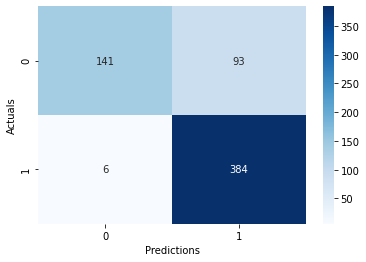

([0.9804], [0.8413])

In [87]:
pret = load_model('/content/saved_models/pre.h5')
PRE = model_evaluation(pret)
PRE

## V. Evaluation

163/163 [==============================] - 11s 64ms/step - loss: 0.2492 - accuracy: 0.9442
Training Loss:0.2492
Training Accuracy:0.9442
20/20 [==============================] - 2s 64ms/step - loss: 0.5034 - accuracy: 0.8446
Test Loss:0.5034
Test Accuracy:0.8446


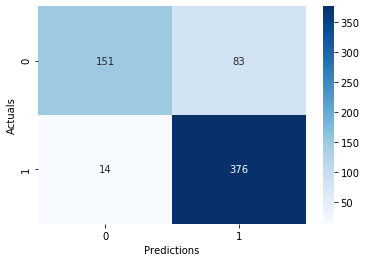

([0.9442], [0.8446])

In [ ]:
best = load_model('/content/saved_models/best_L2.h5')
BEST = model_evaluation(L2)
BEST

In [ ]:
L2.evaluate(X_val, y_val)

1/1 [==============================] - 0s 50ms/step - loss: 0.2613 - accuracy: 0.9375


[0.26126253604888916, 0.9375]

In [ ]:
# Predict for probability of getting 1
L2.predict(X_val)

# predict_proba was deprecated

array([[0.33516 ],
       [0.758586],
       [0.917087],
       [0.022783],
       [0.994851],
       [0.096325],
       [0.827329],
       [0.985   ],
       [0.020615],
       [0.097032],
       [0.082617],
       [0.134354],
       [0.387113],
       [0.03226 ],
       [0.99537 ],
       [0.924776]], dtype=float32)

In [ ]:
# Flatten the array
prob = L2.predict(X_val).flatten()
prob

array([0.33516 , 0.758586, 0.917087, 0.022783, 0.994851, 0.096325,
       0.827329, 0.985   , 0.020615, 0.097032, 0.082617, 0.134354,
       0.387113, 0.03226 , 0.99537 , 0.924776], dtype=float32)

In [ ]:
# Make prediction by using the best model
y_val_pred = ((L2.predict(X_val) > 0.5).astype("int32")).flatten()
y_val_pred

# pad.predict_classes(X_val) was deprecated

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [ ]:
y_act = y_val.astype("int32").flatten()
y_act

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [ ]:
compare_df = pd.concat([pd.Series(y_act, name="Actual"),
                        pd.Series(y_val_pred, name="Predicted"),
                        pd.Series(prob, name="Probabilities")], axis=1)

In [ ]:
compare_df

,Actual,Predicted,Probabilities
0,0,0,0.335160
1,1,1,0.758586
2,1,1,0.917087
3,0,0,0.022783
4,1,1,0.994851
5,0,0,0.096325
6,1,1,0.827329
7,1,1,0.985000
8,0,0,0.020615
9,0,0,0.097032


## VI. Conclusion